# Importing Preprocessed Data and Libraries

In [213]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import eli5
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec

In [183]:
df =pd.read_csv('ICD_preprocessed_dataset',index_col=[0])

In [184]:
df.sample(5)

,Record #,Chief Complaint,Age,Sex,Acuity (initial),Area of Care,Disposition,ICD-9 1,In ED,ICD-level1,class
6552,8622,flank pain,44yr,M,3.0,East,Home,788.0,396.0,788,SYMPTOMS
19221,25537,right lower quadrant pain,36yr,M,3.0,North,Home,789.03,533.0,789,SYMPTOMS
5976,7878,l arm pain,47yr,M,3.0,West,Home,726.90,109.0,726,DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CON...
39468,51899,etoh withdrawl,40yr,M,2.0,Resuscitation,Transfer to Outside Facility,291.81,638.0,291,MENTAL DISORDERS
7699,10114,right knee pain,21yr,F,4.0,West,Home,844.9,113.0,844,INJURY AND POISONING


In [212]:
df['class'].value_counts()

SYMPTOMS                                                                 6520
INJURY AND POISONING                                                     4747
DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE             2766
MENTAL DISORDERS                                                         2665
DISEASES OF THE DIGESTIVE SYSTEM                                         2649
DISEASES OF THE GENITOURINARY SYSTEM                                     2292
DISEASES OF THE RESPIRATORY SYSTEM                                       2121
DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS                          1789
DISEASES OF THE CIRCULATORY SYSTEM                                       1487
DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE                             1424
ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS     871
SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS         811
INFECTIOUS AND PARASITIC DISEASES                               

In [185]:
df.shape

(32088, 11)

In [186]:
df['Sex'].value_counts()

M    17804
F    14284
Name: Sex, dtype: int64

In [187]:
df['Area of Care'].value_counts()

West                     8684
North                    7368
UADC                     3911
East                     3395
Resuscitation            2967
Jail                     1840
Observation              1727
Psych Lock-down          1133
Psych Walk-In             322
Trauma Observation        276
Waiting Adult             227
Psych Walk-in             131
Waiting Main               27
Triage                     17
Waiting Main West          15
Waiting Psych Walk-In      12
Waiting Adult West          4
Ambulance Triage            3
Waiting UADC                3
Name: Area of Care, dtype: int64

In [188]:
df['Disposition'].value_counts()

Home                                   21010
Admit as inpatient                      5485
Transfer to Outside Facility            1227
Jail                                    1059
Home - Refer to Exodus UCC               454
Transfer to Ophtho Eval                  451
Left After Being Seen                    382
Transfer to Psych ED                     369
Jail Infirmary                           330
Against Medical Advice                   246
Transfer to OB Triage/Gyn Procedure      165
Home - Refer to Social Service           164
Transfer to ENT Eval                     155
Transfer to OMF Eval                     136
Rancho-Acute Care                        121
Home - Refer to Psych Walk-In             98
Transfer to Main ED from Psych            51
Transfer to OB Triage                     35
Transfer to GU Treatment                  29
Morgue                                    25
Metro                                     20
Juvenile Hall                             19
Nursing Ho

In [189]:
df = df[df['Chief Complaint'].notnull()] 

# Feature Extraction

In [190]:
count_vect = TfidfVectorizer(binary=False,ngram_range=(1,3)) #min_df= 0.01, max_features=5000
count_vect_fit = count_vect.fit_transform(df['Chief Complaint'])
feature_names = count_vect.get_feature_names()
count_mx = count_vect_fit.todense()
feature_df = pd.DataFrame(count_mx, columns=feature_names)

In [191]:
pd.DataFrame(feature_names).shape

(32594, 1)

In [194]:
feature_df.fillna(0)
print ("computed_features")

computed_features


In [193]:
X, y = feature_df, df['class'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.head()

,aa,aa outpatient,ab,ab htn,ab procedure,abb,abb pain,abc,abc eval,abcess,...,zip,zip tie,zip tie penis,zoster,zoster od,zygoma,zygoma fractures,zygomatic,zygomatic arch,zygomatic arch fx
21981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVM Model

In [197]:
svm_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=20, tol=None,n_jobs=-1).fit(X_train, y_train)

In [198]:
y_pred = svm_clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5546205391927692
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.00      0.00      0.00         3
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.57      0.49      0.53        43
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.54      0.26      0.35       312
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.58      0.36      0.44       566
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.63      0.60      0.62       473
         DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE       0.53      0.60      0.57       526
                      DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS       0.70      0.60      0.65       366
                                   DISEASES OF THE RESPIRATORY SYSTEM       0.62   

/Users/kaushik-shakkari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Analysing SVM features using eli5

In [199]:
eli5.show_weights(svm_clf , vec=count_vect)

In [200]:
eli5.show_weights(svm_clf , vec=count_vect, top=60, feature_filter=lambda x: x != '<BIAS>')

In [201]:
X_test.iloc[0,:].value_counts()

0.000000    32585
0.424182        3
0.263301        1
0.380561        1
0.396660        1
0.083871        1
0.207067        1
0.196986        1
Name: 28416, dtype: int64

# Naive Bayes

In [195]:
nb_clf = MultinomialNB().fit(X_train, y_train)

In [196]:
y_pred = nb_clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5134798192301698
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.00      0.00      0.00         3
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.00      0.00      0.00        43
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.64      0.08      0.14       312
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.67      0.26      0.37       566
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.68      0.49      0.57       473
         DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE       0.58      0.54      0.56       526
                      DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS       0.81      0.49      0.61       366
                                   DISEASES OF THE RESPIRATORY SYSTEM       0.72   

/Users/kaushik-shakkari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression

In [202]:
lr_clf = SGDClassifier(loss='log', penalty='l2', alpha=1e-5, random_state=42, max_iter=20, class_weight='balanced',tol=None, n_jobs=-1).fit(X_train, y_train)

In [203]:
y_pred = svm_clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5546205391927692
                                                                       precision    recall  f1-score   support

               CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.00      0.00      0.00         3
           COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.57      0.49      0.53        43
                                   DISEASES OF THE CIRCULATORY SYSTEM       0.54      0.26      0.35       312
                                     DISEASES OF THE DIGESTIVE SYSTEM       0.58      0.36      0.44       566
                                 DISEASES OF THE GENITOURINARY SYSTEM       0.63      0.60      0.62       473
         DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE       0.53      0.60      0.57       526
                      DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS       0.70      0.60      0.65       366
                                   DISEASES OF THE RESPIRATORY SYSTEM       0.62   

/Users/kaushik-shakkari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Pickling models

In [204]:
pickle.dump(svm_clf, open('svm_model', 'wb'))

In [205]:
pickle.dump(lr_clf, open('lr_model', 'wb'))

In [206]:
pickle.dump(nb_clf, open('nb_model', 'wb'))

# Testing with Logistic Regression Model

In [207]:
lr_clf = pickle.load(open('lr_model', 'rb')) 

In [211]:
test_text = "heart"

print(lr_clf.predict(count_vect.transform([test_text])))

proba = lr_clf.predict_proba(count_vect.transform([test_text]))[0]

percent = (proba * 100.0) / np.sum(proba)

['SYMPTOMS']


In [57]:
analysis = df[['class']].drop_duplicates()

analysis.sort_values('class',inplace = True)

analysis = analysis.reset_index()

analysis.drop(['index'],axis = 1, inplace = True)

analysis['Probability_Percentage'] = percent 

analysis.sort_values('Probability_Percentage',inplace = True, ascending = False)

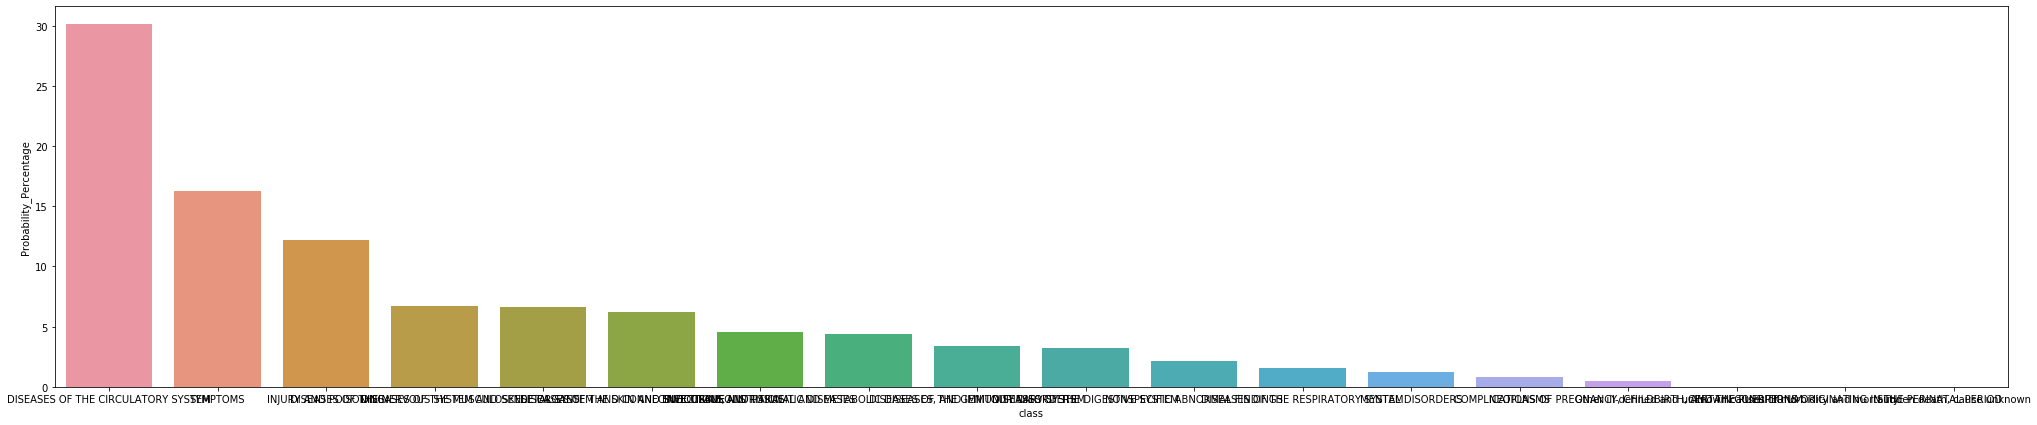

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(35,7))
sns.barplot(x = 'class',y='Probability_Percentage', data = analysis)

In [59]:
analysis

,class,Probability_Percentage
2,DISEASES OF THE CIRCULATORY SYSTEM,3.010671e+01
16,SYMPTOMS,1.624250e+01
11,INJURY AND POISONING,1.222171e+01
6,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,6.677673e+00
5,DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CON...,6.659394e+00
8,DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE,6.216496e+00
10,INFECTIOUS AND PARASITIC DISEASES,4.584162e+00
9,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...",4.423689e+00
4,DISEASES OF THE GENITOURINARY SYSTEM,3.426986e+00
3,DISEASES OF THE DIGESTIVE SYSTEM,3.226691e+00


# Generating word ICD probability vector

In [232]:
sentences = df['Chief Complaint']

In [235]:
sentences = sentences.str.split()

In [237]:
sentences[0]

['nausea', 'vomiting', 'hx', 'ca']

In [238]:
model = Word2Vec(sentences)

In [241]:
words = list(model.wv.vocab)

In [242]:
words

['nausea',
 'vomiting',
 'hx',
 'ca',
 'earache',
 'right',
 'foot',
 'pain',
 'danger',
 'others',
 'leg',
 'laceration',
 'weakness',
 'rt',
 'rue',
 'inflammation',
 'diarrhea',
 'wrist',
 'fx',
 'ortho',
 'f',
 'u',
 'l',
 'eye',
 'visual',
 'changes',
 'depressed',
 'suicidal',
 'ideations',
 'abdominal',
 'blunt',
 'head',
 'trauma',
 'fall',
 'sob',
 'allergic',
 'reaction',
 'chest',
 'bipolar',
 'heart',
 'fast',
 'rib',
 'cough',
 'left',
 'hip',
 'mvc',
 'p',
 'altercation',
 'assault',
 'body',
 'ankle',
 'injury',
 'breast',
 'glf',
 'unable',
 'void',
 'headaches',
 'behavior',
 'infected',
 'finger',
 'altered',
 'mental',
 'status',
 'found',
 'asthma',
 'psych',
 'exam',
 'back',
 'boil',
 'buttock',
 'sore',
 'throat',
 'man',
 'mva',
 'fever',
 'chills',
 'ams',
 'wound',
 'th',
 'digit',
 'medication',
 'refill',
 'recheck',
 'check',
 'auditory',
 'hallucination',
 'hi',
 'si',
 'coughing',
 'blood',
 'needs',
 'insulin',
 'flu',
 'like',
 'symptoms',
 'extremity',

In [264]:
df['class'].unique().shape

(22,)

In [271]:
temp = [val.upper() for val in df['class'].unique().tolist()]

ICD_df = pd.DataFrame(columns = temp)

In [272]:
ICD_df

,SYMPTOMS,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS,MENTAL DISORDERS,INJURY AND POISONING,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS",DISEASES OF THE DIGESTIVE SYSTEM,DISEASES OF THE RESPIRATORY SYSTEM,EXTERNAL CAUSES FOR INJURY,DISEASES OF THE GENITOURINARY SYSTEM,...,DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE,DISEASES OF THE CIRCULATORY SYSTEM,INFECTIOUS AND PARASITIC DISEASES,"COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM",NONSPECIFIC ABNORMAL FINDINGS,MISADVENTURES TO PATIENTS DURING SURGICAL AND MEDICAL CARE,OTHERS,OTHER ILL-DEFINED AND UNKNOWN CAUSES OF MORBIDITY AND MORTALITY,CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD,"SUDDEN DEATH, CAUSE UNKNOWN"


In [273]:
proba = lr_clf.predict_proba(count_vect.transform(["chest"]))[0]

percent = (proba * 100.0) / np.sum(proba)

percent

array([4.72738018e-95, 5.81900606e-02, 2.11660778e+01, 5.68745456e-01,
       4.36593433e-01, 3.96036770e-01, 2.67437432e-01, 1.10601416e+01,
       1.33239536e+00, 4.42992235e+00, 1.61655165e-01, 2.76109242e+00,
       8.33201905e-01, 3.86729951e+00, 7.41181043e-11, 3.94098434e+00,
       6.46318785e-01, 5.81307181e-09, 1.73002989e-02, 9.50323837e-01,
       4.71062835e+01, 4.11702728e-19])

In [274]:
li = []

for word in words:
    print 
    proba = lr_clf.predict_proba(count_vect.transform([word]))[0]
    percent = (proba * 100.0) / np.sum(proba)
    percent = [word] + list(percent)
    li.append(percent)
    
ICD_df = pd.DataFrame(li,columns = ['word'] + temp)

In [275]:
ICD_df.to_csv('ICD_word_probabilities.csv')

In [277]:
ICD_df.head()

,word,SYMPTOMS,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS,MENTAL DISORDERS,INJURY AND POISONING,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS",DISEASES OF THE DIGESTIVE SYSTEM,DISEASES OF THE RESPIRATORY SYSTEM,EXTERNAL CAUSES FOR INJURY,...,DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE,DISEASES OF THE CIRCULATORY SYSTEM,INFECTIOUS AND PARASITIC DISEASES,"COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM",NONSPECIFIC ABNORMAL FINDINGS,MISADVENTURES TO PATIENTS DURING SURGICAL AND MEDICAL CARE,OTHERS,OTHER ILL-DEFINED AND UNKNOWN CAUSES OF MORBIDITY AND MORTALITY,CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD,"SUDDEN DEATH, CAUSE UNKNOWN"
0,nausea,1.820907e-92,0.262123,1.859948,24.939075,4.992269,1.012069,6.529853,1.149940,1.108656,...,2.332014,4.311146,2.472792e-09,3.725267,0.167361,1.764590e-07,0.000049,0.918935,32.189889,1.129186e-16
1,vomiting,3.177808e-93,0.136892,0.332451,13.984640,1.962758,0.183602,3.847785,2.467111,2.453870,...,1.254860,1.241318,4.840888e-10,20.686830,19.294563,1.030286e-08,0.000008,1.133498,16.258696,8.481011e-18
2,hx,7.947040e-93,0.149980,6.955346,13.164250,1.676974,2.060707,1.936477,20.322253,3.417717,...,0.728011,3.078218,1.194042e-09,20.142558,0.235433,7.741657e-08,0.002297,1.510692,9.101724,6.915323e-17
3,ca,8.823306e-93,0.227851,0.543118,3.935066,0.977335,1.910305,1.466141,2.499494,1.594690,...,2.195526,4.499913,1.636450e-09,68.562742,1.857896,1.336470e-07,0.000023,0.999268,4.398722,8.934869e-17
4,earache,1.324770e-92,0.211120,0.609459,1.089620,0.379043,0.589531,79.462711,8.930694,1.013643,...,1.968717,1.158115,1.429986e-09,0.813135,0.283441,1.573321e-07,0.000027,0.855715,1.192556,8.883270e-17
